In [1]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import operator

people.image.shape:(2537, 87, 65)
Number of classes:45
Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Ariel Sharon               77 Atal Bihari Vajpayee       24 
Bill Clinton               29 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Hamid Karzai               22 Hans Blix                  39 Hugo Chavez                71 
Igor Ivanov                20 Jack Straw                 28 Jacques Chirac             52 
Jean Chretien              55 Jennifer Aniston           21 Jennifer Capriati          42 
Jennifer Lopez             21 John Ashcroft              53 Juan Carlos Ferrero        28 
Junichiro Koizumi          60 Kofi Annan                 32 Laura Bush                 41 
Lindsay Davenport          22 Lleyt

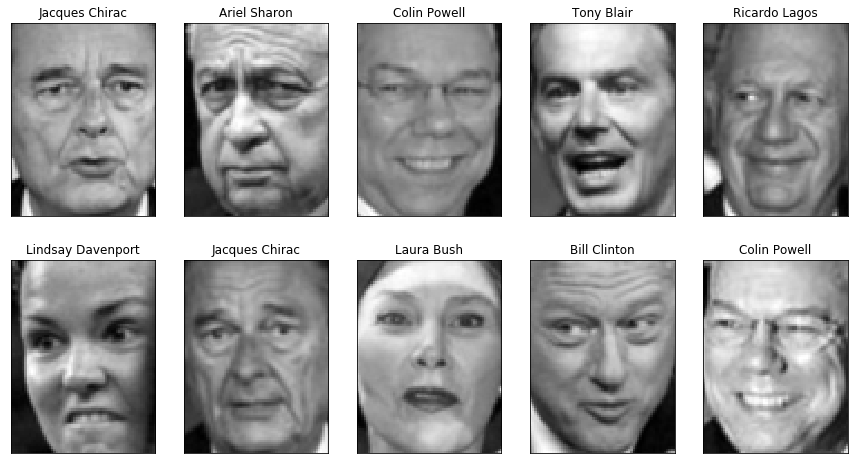

In [2]:
people = fetch_lfw_people(min_faces_per_person = 20, resize=0.7)
image_shape = people.images[0].shape
fig,axes = plt.subplots(2,5,figsize=(15,8),subplot_kw={'xticks':(),'yticks':()})

for target, image, ax in zip(people.target, people.images,axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])

print("people.image.shape:{}".format(people.images.shape))
print("Number of classes:{}".format(len(people.target_names)))

counts = np.bincount(people.target)
for i, (count,name) in enumerate(zip(counts,people.target_names)):
    print('{0:25} {1:3}'.format(name,count), end =' ')
    if (i+1)%3 == 0:
        print()

In [3]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target) :
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask]
y_people = people.target[mask]
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_people,y_people,stratify=y_people, random_state=0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

print(f'Test set score of 1-nn {knn.score(X_test,y_test)}')

Test set score of 1-nn 0.27848101265822783


In [5]:
def ED(x1, x2):  # it is used for calculating euclidean distance
    
    vector=(x1-x2)**2
    sm=np.sum(vector)
    return np.sqrt(sm)

def standardise(X_train,X_test):
    mean = np.mean(X_train, axis=0)
    scale = np.std(X_train, axis=0, ddof=1)
    X_std = (X_train - mean) / scale
    Xte_std = (X_test - mean) / scale
    return X_std,Xte_std

def Eigen(c_mat,d):
    e_vals, e_vecs = np.linalg.eig(c_mat)
    #print('Eigenvectors \n%s' % e_vecs)
    #print('\nEigenvalues \n%s' % e_vals)
    e_vals2 = e_vals.argsort()[-d:]
    val = e_vals[e_vals2[::-1]]
    e_vecs2 = e_vecs[:, e_vals2[::-1]]
    return val,e_vecs2

def knn(X_train, y_train, sample):  # here we are defining our model
    # Function takes one sample, returns label based on on Xtrain
    currentDist = 1e5
    currentPred = -1
    for xtrain,ytrain in zip(X_train,y_train): 
        dist = ED(xtrain, sample)
        if dist < currentDist:
            currentDist = dist
            currentPred = ytrain

    return currentPred

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

correct = 0
for idx,sample in enumerate(X_test):
     pred = knn(X_train,y_train,sample)
     if pred == y_test[idx]:
         correct+=1
accuracy = correct / len(y_test)
print("accuracy with KNN is:", accuracy)

def PCA(e_vec2,X_std):
    x_d = X_std @ e_vec2
    x_d = [X_std @ e_vec2[:,i] for i in range(e_vec2.shape[1])]
    x_d = np.array(x_d).T
    return x_d

def PCA_whiten(e_vals2,e_vec2,X_std):
    x_d=np.dot(X_std,e_vec2)
#     xtr_dim= xtr_dim / np.sqrt(e_vals2) 
    x_d = [ (X_std @ e_vec2[:,i])/np.sqrt(e_vals2[i]) for i in range(e_vec2.shape[1])]
    x_d = np.array(x_d).T
    return x_d



accuracy with KNN is: 0.27848101265822783


In [6]:
X_std,Xte_std = standardise(X_train,X_test)
c_mat = X_std.T @ X_std
print('Covariance matrix \n {}'.format(c_mat))


e_val,evecs = Eigen(c_mat,d=100)
x_d = PCA(evecs,X_std)
xtest_dim = PCA(evecs,Xte_std)

correct = 0
for sample,actual in zip(xtest_dim,y_test): 
    pred = knn(x_d,y_train,sample)
    if pred == actual:
        correct+=1
    #print(len(xtr_dim))
accuracy = correct / len(y_test)
print("Accuracy with PCA D=100 is:", accuracy)


Covariance matrix 
 [[1181.0004   1159.3176   1101.4296   ...  -49.719658  -62.427204
   -61.361485]
 [1159.3176   1181.0013   1154.453    ...  -49.502506  -60.78466
   -61.534943]
 [1101.4296   1154.453    1181.0011   ...  -49.262463  -62.93709
   -66.15958 ]
 ...
 [ -49.719658  -49.502506  -49.262463 ... 1181.0007   1131.0781
  1034.6715  ]
 [ -62.427204  -60.78466   -62.93709  ... 1131.0781   1181.0006
  1144.5018  ]
 [ -61.361485  -61.534943  -66.15958  ... 1034.6715   1144.5018
  1180.9996  ]]
Accuracy with PCA D=100 is: 0.3012658227848101


In [7]:
e_val,evecs = Eigen(c_mat,d=100)
x_d = PCA_whiten(e_val,evecs,X_std)
xtest_dim = PCA_whiten(e_val,evecs,Xte_std)

correct = 0
for sample,actual in zip(xtest_dim,y_test):
    pred = knn(x_d,y_train,sample)
    if pred == actual:
        correct+=1
    #print(pred)
accuracy = correct / len(y_test)
print("Accuracy with PCA whitened D=100 is:", accuracy)

Accuracy with PCA whitened D=100 is: 0.3468354430379747


In [8]:
def PCA_2D(e_vec2,X_std,d=2):
    x_d = X_std @ e_vec2
    #xtr_dim = np.array(xtr_dim).T
    return x_d

e_val,evecs = Eigen(c_mat,d=2)
x_2D= PCA_2D(evecs,X_std,d=2)

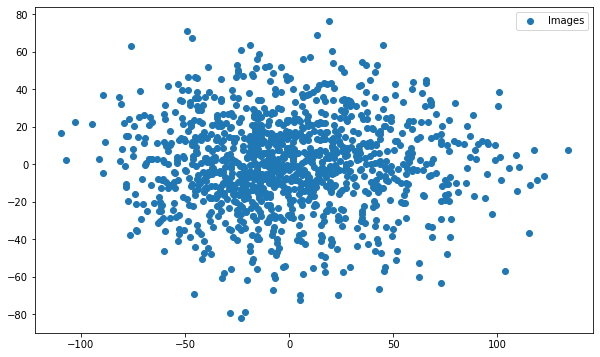

In [9]:
fig = plt.figure(figsize=(10,6))
plt.scatter(x_2D[:,0],x_2D[:,1],label='Images')
plt.legend()